In [ ]:
!unzip folders.zip
# !ls -al

Archive:  folders.zip
  inflating: .DS_Store               
  inflating: models.py               
  inflating: evaluate_jpeg.py        
  inflating: dataset_utils.py        
   creating: bpe/
  inflating: bpe/.DS_Store           
  inflating: bpe/bpe_simple_vocab_16e6.txt.gz  
   creating: imagebind/
  inflating: imagebind/__init__.py   
   creating: imagebind/models/
 extracting: imagebind/models/__init__.py  
  inflating: imagebind/models/imagebind_model.py  
  inflating: imagebind/models/transformer.py  
  inflating: imagebind/models/multimodal_preprocessors.py  
  inflating: imagebind/models/helpers.py  
  inflating: imagebind/data.py       
  inflating: evaluate_illusions.py   
   creating: image/
  inflating: image/perturbed_street.png  
  inflating: image/street.png        
  inflating: image/illusion.png      
  inflating: utils.py                
   creating: DiffJPEG/
  inflating: DiffJPEG/LICENSE        
  inflating: DiffJPEG/decompression.py  
  inflating: DiffJPEG/compress

In [ ]:
!pip install -U pytorchvideo torchvision==0.14.1 torchaudio==0.13.1 ftfy==6.1.1 open-clip-torch==2.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 53.2 MB/s eta 0:00:00
   

In [ ]:
from pathlib import Path

from tqdm import tqdm
import toml

import numpy as np

import torch
import torch.optim as optim

from utils import threshold, criterion, unnorm
from dataset_utils import imagenet_loader
from models import load_model
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image
# Configure Script
configs = []
config_dir = Path('configs/imagenet/whitebox')
for config_file in config_dir.glob('*.toml'):
    if config_file == Path("configs/imagenet/whitebox/openclip.toml") or config_file == Path("configs/imagenet/whitebox/imagebind.toml"):
      configs.append(toml.load(config_file)['general'])

config = configs[0]

gpu_num = config['gpu_num']
epochs = config['epochs']
batch_size = config['batch_size']
eps = config['epsilon']
lr = config['lr']
seed = config['seed']
output_dir = config['output_dir']
n_images = config['number_images']
model_flag = config.get('model_flag', 'imagebind')
embs_input = config.get('embeddings_input', output_dir + 'embs.npy')\
                   .format(model_flag)
gamma_epochs = config.get('gamma_epochs', 100)
modality = config.get('modality', 'vision')
dataset_flag = config.get('dataset_flag', 'imagenet')

if modality == 'vision':
    eps = eps / 255

if type(epochs) == list:
    max_epochs = max(epochs)
else:
    max_epochs = epochs
    epochs = [epochs]

Path(output_dir).mkdir(parents=True, exist_ok=True)

device = f"cuda:{gpu_num}" if torch.cuda.is_available() and gpu_num >= 0 else "cpu"
assert n_images % batch_size == 0

# Instantiate Model
models = []
for cfg in configs:
    model_flag = cfg.get('model_flag', 'imagebind')
    models.append(load_model(model_flag, device))
    print("here")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab

here
here


In [ ]:
def contrastive_loss(embeds_i, embeds_j, y_i, y_j, epsilon):
    """
    Computes the contrastive loss for a pair of embeddings and labels.

    Parameters:
        embeds_i: Embedding of sample i (Tensor)
        embeds_j: Embedding of sample j (Tensor)
        y_i: Label of sample i (Tensor or int)
        y_j: Label of sample j (Tensor or int)
        epsilon: Margin parameter for negative pairs (float)

    Returns:
        loss: Computed contrastive loss (Tensor)
    """
    # Check if the labels are the same
    positive_mask = (y_i == y_j).float()
    negative_mask = (y_i != y_j).float()

    # Compute squared L2 distance between embeddings
    distance_sq = torch.norm(embeds_i - embeds_j, p=2, dim=1) ** 2

    # Loss for positive pairs (same labels)
    positive_loss = positive_mask * distance_sq

    # Loss for negative pairs (different labels)
    negative_loss = negative_mask * torch.relu(epsilon - distance_sq)

    # Combine and average the loss
    loss = positive_loss + negative_loss
    return loss.mean()

  0%|          | 0/2000 [00:00<?, ?it/s, loss=tensor(1.2478), eta=0.02]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 2000/2000 [24:56<00:00,  1.34it/s, loss=tensor(0.2191), eta=0.0106]


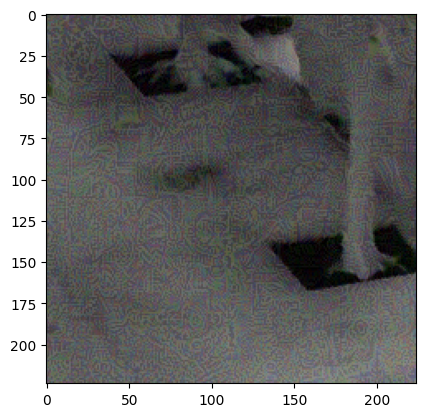

In [ ]:
X_path = 'image/street.png'
X=imagenet_loader(X_path,models[0], device)
X_init = X.clone().detach().cpu().requires_grad_(False)
target_text=["broccoli",]
Y_list = []
for model in models:
      Y_list.append(model.forward(target_text, "text", normalize=False).to(device))
X = X.to(device).requires_grad_(True)

max_epochs=2000
pbar = tqdm(range(max_epochs))
X_init = X.clone().detach().cpu().requires_grad_(False)
X = X.to(device).requires_grad_(True)
X_max, X_min = threshold(X, eps, modality, device)
optimizer = optim.SGD([X], lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                            np.arange(gamma_epochs, max_epochs, gamma_epochs),
                                            gamma=0.9)
for j in pbar:
    eta = scheduler.get_last_lr()[0]
    embeds = model.forward(X, modality, normalize=False)
    # Calculate embeddings and losses for all models
    losses = []
    for model, Y in zip(models, Y_list):
        cton = 1 - criterion(embeds, Y, dim=1).detach().cpu()
        embeds = model.forward(X, modality, normalize=False)
        model_loss = 1 - criterion(embeds, Y, dim=1)
        losses.append(model_loss)
    combined_loss = torch.norm(torch.stack(losses), p=2)
    update = eta * torch.autograd.grad(outputs=combined_loss, inputs=X)[0].sign()
    X = (X.detach().cpu() - update.detach().cpu()).to(device)
    X = torch.clamp(X, min=X_min, max=X_max).requires_grad_(True)
    pbar.set_postfix({'loss': combined_loss.detach().cpu(), 'eta': eta})
    scheduler.step()

transform = transforms.ToPILImage()
plt.imshow(transform(unnorm(torch.squeeze(X))[0]))
plt.show()
save_image(unnorm(torch.squeeze(X.cuda()))[0], 'image/perturbed_lettuce.png')

  0%|          | 0/2000 [00:00<?, ?it/s, loss=tensor(724.0935), eta=0.02]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 2000/2000 [23:43<00:00,  1.40it/s, loss=tensor(142.0336), eta=0.0106]


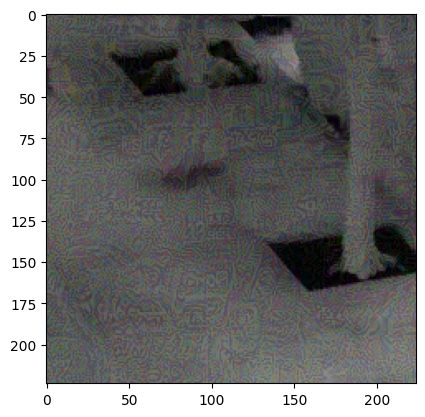

In [ ]:
X_path = 'image/street.png'
X=imagenet_loader(X_path,models[0], device)
X_init = X.clone().detach().cpu().requires_grad_(False)
target_text=["broccoli",]
Y_list = []
y_org = model.forward("street", "text", normalize=False).to(device)
for model in models:
      Y_list.append(model.forward(target_text, "text", normalize=False).to(device))
X = X.to(device).requires_grad_(True)

max_epochs=2000
pbar = tqdm(range(max_epochs))
X_init = X.clone().detach().cpu().requires_grad_(False)
X = X.to(device).requires_grad_(True)
X_max, X_min = threshold(X, eps, modality, device)
optimizer = optim.SGD([X], lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                            np.arange(gamma_epochs, max_epochs, gamma_epochs),
                                            gamma=0.9)
for j in pbar:
    eta = scheduler.get_last_lr()[0]
    embeds = model.forward(X, modality, normalize=False)
    # Calculate embeddings and losses for all models
    losses = []
    for model, Y in zip(models, Y_list):
        cton = 1 - criterion(embeds, Y, dim=1).detach().cpu()
        embeds = model.forward(X, modality, normalize=False)
        contrastive = contrastive_loss(embeds, Y, y_i=torch.tensor([1]).to(device), y_j=torch.tensor([1]).to(device), epsilon=eps)+contrastive_loss(embeds, y_org, y_i=torch.tensor([1]).to(device), y_j=torch.tensor([0]).to(device), epsilon=eps)
        losses.append(contrastive)
    combined_loss = torch.norm(torch.stack(losses), p=2)
    update = eta * torch.autograd.grad(outputs=combined_loss, inputs=X)[0].sign()
    X = (X.detach().cpu() - update.detach().cpu()).to(device)
    X = torch.clamp(X, min=X_min, max=X_max).requires_grad_(True)
    pbar.set_postfix({'loss': combined_loss.detach().cpu(), 'eta': eta})
    scheduler.step()

transform = transforms.ToPILImage()
plt.imshow(transform(unnorm(torch.squeeze(X))[0]))
plt.show()
save_image(unnorm(torch.squeeze(X.cuda()))[0], 'image/perturbed_lettuce.png')